In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [9]:
# !wget http://ipsar.fesb.unist.hr/ipsar_data/heridal.zip

In [4]:
# !mkdir heridal

In [5]:
# !unzip ./heridal.zip -d ./heridal

In [10]:
!ls ../heridal

patches  testImages  trainImages


In [11]:
import drone_sar

In [12]:
from drone_sar.ipsar_dataset import IPSARDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [14]:
train_data = IPSARDataset("../heridal/trainImages/")
test_data = IPSARDataset("../heridal/testImages")

In [15]:
item = test_data[0]

In [16]:
item.keys()

dict_keys(['img_path', 'pil', 'pixel_values', 'boxes', 'class_labels'])

In [17]:
item['pixel_values'].shape

torch.Size([3000, 4000, 3])

In [18]:
item["boxes"].shape

torch.Size([2, 4])

In [19]:
item["class_labels"].shape

torch.Size([2])

In [20]:
# data[0]

In [21]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

In [22]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/home/iz/.cache/pypoetry/virtualenvs/drone-sar-xLdq85T6-py3.10/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/iz/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [23]:
# item['pil']

In [24]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = item['pil']

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [25]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

In [37]:
# processor??

In [26]:
device = "cuda"

In [27]:
model = model.eval().to(device)

In [28]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [29]:
outputs = []
with torch.inference_mode():
    for item in tqdm(train_data + test_data):
        image = item['pil']
        inputs = processor(images=image, return_tensors="pt")
        pv = inputs["pixel_values"].to(device)
        pm = inputs["pixel_mask"].to(device)
        out = model(pixel_values=pv, pixel_mask=pm)
        outputs.append(out)

  0%|          | 0/1684 [00:00<?, ?it/s]


KeyboardInterrupt



In [39]:
# model??

In [35]:
item["class_labels"]

tensor([], dtype=torch.int64)

In [42]:
post_proc_outs = []
for outputs in outputs:
    outputs["logits"] = outputs["logits"].cpu().detach()
    outputs["pred_boxes"] = outputs["pred_boxes"].cpu().detach()
    
    post_proc = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=0.1
    )[0]
    post_proc_outs.append(post_proc)

In [43]:
train_data = IPSARDataset("./heridal/heridal/trainImages", load_images=False)
test_data = IPSARDataset("./heridal/heridal/testImages", load_images=False)

In [44]:
all_data = list(train_data + test_data)

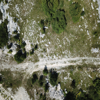

In [45]:
all_data[0]["pil"]().resize((100, 100))

In [46]:
len(results)

1684

In [47]:
import torchmetrics

In [50]:
mean_ap = torchmetrics.detection.mean_ap.MeanAveragePrecision()

In [49]:
len([el for el in all_data if len(el["boxes"]) > 0])

1086

In [40]:
len([r for r in post_proc_outs if len(r["scores"]) > 0])

906

In [56]:
all_data[0]

{'img_path': './heridal/heridal/trainImages/train_RAK_0072.JPG',
 'pil': <function drone_sar.ipsar_dataset.IPSARDataset.__getitem__.<locals>.<lambda>()>,
 'pixel_values': <function drone_sar.ipsar_dataset.IPSARDataset.__getitem__.<locals>.<lambda>()>,
 'boxes': tensor([[2088., 2127., 2136., 2181.]]),
 'class_labels': tensor([1])}

In [97]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [137]:
CLASSES[16]

'bird'

In [58]:
target = [{"boxes": item["boxes"], "labels": item["class_labels"]} for item in all_data]

In [135]:
from collections import Counter

In [140]:
Counter([(CLASSES[i], i) for i in torch.cat([p["labels"] for p in preds]).tolist()]).most_common(10)

[(('person', 1), 3968),
 (('broccoli', 56), 2162),
 (('bird', 16), 1665),
 (('bench', 15), 612),
 (('car', 3), 240),
 (('boat', 9), 202),
 (('traffic light', 10), 197),
 (('truck', 8), 193),
 (('umbrella', 28), 179),
 (('airplane', 5), 167)]

In [165]:
def post_proc(p):
    res = {"scores": [], "labels": [], "boxes": []}
    for i in range(len(p["scores"])):
        s = p["scores"][i]
        l = p["labels"][i]
        b = p["boxes"][i].tolist()
        if CLASSES[l] == "person":
            res["scores"].append(s)
            res["labels"].append(l)
            res["boxes"].append(b)
    return {
        "scores": torch.tensor(res["scores"]),
        "labels": torch.tensor(res["labels"]),
        "boxes": torch.tensor(res["boxes"]),
    }

In [166]:
preds = [post_proc(p) for p in post_proc_outs]

tensor([[2088., 2127., 2136., 2181.]])

In [185]:
def tensor_image(img):
    if isinstance(img, torch.Tensor):
        return img
    if isinstance(img, str) or isinstance(img, Path):
        return ToTensor()(Image.open(img).convert('RGB'))
    raise TypeError

In [218]:
import numpy as np
from pathlib import Path
from torchvision.transforms import ToTensor
import cv2

def show_image(image, boxes=[], probabilities=None, probability_treshold=0.0, title=None):
    image = np.ascontiguousarray(np.transpose(tensor_image(image).numpy(), (1, 2, 0)))
    
    if probabilities is None:
        probabilities = [1.0 for _ in boxes]

    for probability, box in sorted(list(zip(probabilities, boxes))):
        if probability < probability_treshold:
            continue
        x = int(box[0] * image.shape[1])
        y = int(box[1] * image.shape[0])
        w = int(box[2] * image.shape[1])
        h = int(box[3] * image.shape[0])
        cv2.rectangle(image, (x, y), (x + w, y+h), (probability, 0.0, 0.0), int(image.shape[1] * 0.001)) 
            
    plt.figure(figsize=(32, 32))
    plt.imshow(image)
    # if title is not None:
    #     print(title)
    plt.axis('off')
    plt.show()

In [219]:
all_data[0]["img_path"]

'./heridal/heridal/trainImages/train_RAK_0072.JPG'

In [231]:
# [(i, len(t["boxes"])) for i, t in enumerate(target)]

In [232]:
# show_image(all_data[10]["img_path"], target[10]["boxes"])

In [168]:
# preds

In [169]:
preds[0]

{'scores': tensor([]), 'labels': tensor([]), 'boxes': tensor([])}

In [170]:
# preds = [
#     {}
#     for pred in post_proc_outs
# ]

In [180]:
from torch import tensor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# preds = [dict(
#     boxes=tensor([[258.0, 41.0, 606.0, 285.0]]),
#     scores=tensor([0.536]),
#     labels=tensor([0]),
# )]
# target = [dict(
#     boxes=tensor([[214.0, 41.0, 562.0, 285.0]]),
#     labels=tensor([0]),
# )]
metric = MeanAveragePrecision(
    extended_summary=True
)
metric.update(preds, target)

In [181]:
len(preds)

1684

In [182]:
metric_res = metric.compute()

In [183]:
metric_res

{'map': tensor(0.0226),
 'map_50': tensor(0.0618),
 'map_75': tensor(0.0123),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0207),
 'map_large': tensor(0.0511),
 'mar_1': tensor(0.0144),
 'mar_10': tensor(0.0408),
 'mar_100': tensor(0.0642),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.0613),
 'mar_large': tensor(0.1432),
 'ious': {(0, 1.0): [],
  (1, 1.0): [],
  (2, 1.0): [],
  (3, 1.0): [],
  (4, 1.0): [],
  (5, 1.0): [],
  (6, 1.0): [],
  (7, 1.0): [],
  (8, 1.0): [],
  (9, 1.0): [],
  (10, 1.0): [],
  (11, 1.0): [],
  (12, 1.0): [],
  (13, 1.0): [],
  (14, 1.0): [],
  (15, 1.0): [],
  (16, 1.0): [],
  (17, 1.0): [],
  (18, 1.0): [],
  (19, 1.0): [],
  (20, 1.0): [],
  (21, 1.0): [],
  (22, 1.0): [],
  (23, 1.0): [],
  (24, 1.0): [],
  (25, 1.0): [],
  (26, 1.0): tensor([[0.4485, 0.0000, 0.0000, 0.0000]]),
  (27, 1.0): [],
  (28, 1.0): [],
  (29, 1.0): [],
  (30, 1.0): [],
  (31, 1.0): [],
  (32,
   1.0): tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.00

In [ ]:
[i for i in metric_res["ious"].values() if len(i) > 0][0]

In [92]:
metric_res["classes"]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 27, 28, 31, 33, 34, 35, 36, 37, 38, 40, 41, 53, 56, 62,
        64, 70, 77, 84, 85], dtype=torch.int32)

In [27]:
# results = []